#Ensemble Learning Voting

##Load, Install, Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle

for dirname, _, filenames in os.walk('drive/MyDrive/dataset/texts/'): #path file
    for filename in filenames:
        print(os.path.join(dirname, filename))

drive/MyDrive/dataset/texts/dev_sent_emo.csv
drive/MyDrive/dataset/texts/test_sent_emo.csv
drive/MyDrive/dataset/texts/train_sent_emo.csv
drive/MyDrive/dataset/texts/df_train.csv


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize, MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef
from sklearn.utils import resample,shuffle

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
# import torch, torchaudio

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.5 MB/s 
     |████████████████████████████████| 7.6 MB 46.3 MB/s 
     |████████████████████████████████| 182 kB 74.1 MB/s 


In [ ]:
!pip install natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load and Preprocess Datasets

###Load Datasets

In [ ]:
from natsort import natsorted
#load paths for train data
# paths_train = []
# labels_train = []
# for dirname, _, filenames in os.walk('drive/MyDrive/dataset/train_splits'):
#   sorted_fl = natsorted(filenames)
#   for filename in sorted_fl:
#     paths_train.append(os.path.join(dirname, filename))

df_train = pd.read_csv("drive/MyDrive/dataset/texts/train_sent_emo.csv", delimiter=',', header=0, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])
labels_train = df_train['Emotion']
utter_train = df_train['Utterance']
# df_train = pd.read_csv("drive/MyDrive/dataset/texts/df_train.csv", delimiter=',',header=0)
# labels_train = df_train['label']
# utter_train = df_train['utterance']

#load paths for train data
# paths_test = []
# labels_test = []
# for dirname, _, filenames in os.walk('drive/MyDrive/dataset/output_repeated_splits_test'):
#   sorted_fl = natsorted(filenames)
#   for filename in sorted_fl:
#     if filename.find('._') == 0:
#       continue
#     elif filename.find('final') == 0:
#       continue
#     else:
#       paths_test.append(os.path.join(dirname, filename))

df_test = pd.read_csv("drive/MyDrive/dataset/texts/test_sent_emo.csv", delimiter=',', header=0, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])
labels_test = df_test['Emotion']
utter_test = df_test['Utterance']

### Remove Fear and Disgust Train Dataset


In [ ]:
print(df_train['Emotion'].value_counts())

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Emotion, dtype: int64


In [ ]:
# df_train = df_train.drop(df_train.index[1165])

In [ ]:
df_tr_temp = pd.DataFrame()
df_tr_temp['utterance'] = df_train['Utterance']
df_tr_temp['label'] = df_train['Emotion']
# df_tr_temp['speech'] = paths_train

In [ ]:
df_tr_temp = df_tr_temp[df_tr_temp['label'] != 'fear']
df_tr_temp = df_tr_temp[df_tr_temp['label'] != 'disgust']

df_tr_temp['label'].value_counts()

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
Name: label, dtype: int64

In [ ]:
df_emo_1 = df_tr_temp[df_tr_temp['label'] == 'neutral']
df_1_upsampled = resample(df_emo_1,random_state=42,n_samples=683,replace=True)

df_emo_2 = df_tr_temp[df_tr_temp['label'] == 'joy']
df_2_upsampled = resample(df_emo_2,random_state=0,n_samples=683,replace=True)

df_emo_3 = df_tr_temp[df_tr_temp['label'] == 'surprise']
df_3_upsampled = resample(df_emo_3,random_state=42,n_samples=683,replace=True)

df_emo_4 = df_tr_temp[df_tr_temp['label'] == 'anger']
df_4_upsampled = resample(df_emo_4,random_state=42,n_samples=683,replace=True)

df_emo_5 = df_tr_temp[df_tr_temp['label'] == 'sadness']
# df_emo_6 = df_tr_temp[df_tr_temp['label'] == 'fear']
# df_emo_7 = df_tr_temp[df_tr_temp['label'] == 'disgust']

# df_tr_path = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,df_emo_5,df_emo_6,df_emo_7])
df_tr_path = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,df_emo_5])
# df_tr_path = pd.concat([df_1_upsampled,df_2_upsampled,df_4_upsampled,df_emo_5])
                        
df_tr_path['label'].value_counts()

neutral     683
joy         683
surprise    683
anger       683
sadness     683
Name: label, dtype: int64

In [ ]:
df_tr_path = df_tr_path.sample(frac=1,random_state=42).reset_index(drop=True)

###Remove Fear and Disgust from Test Dataset

In [ ]:
df_test_temp = pd.DataFrame()
# df_test_temp['speech'] = paths_test
df_test_temp['utterance'] = utter_test
df_test_temp['label'] = labels_test

In [ ]:
# df_test_temp['utterance'].fillna('I mean weÂ’re not, weÂ’re not gonna live together anymore?',inplace = True)

In [ ]:
df_test_temp['label'].value_counts()

neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: label, dtype: int64

In [ ]:
df_test_temp = df_test_temp[df_test_temp['label'] != 'fear']
df_test_temp = df_test_temp[df_test_temp['label'] != 'disgust']

df_test_temp['label'].value_counts()

neutral     1256
joy          402
anger        345
surprise     281
sadness      208
Name: label, dtype: int64

In [ ]:
df_test_path = df_test_temp

###Emotions in Train and Test Dataset

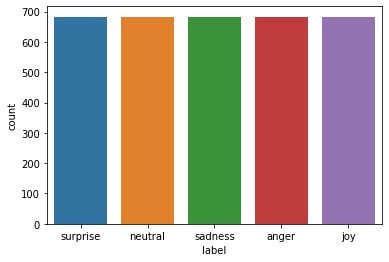

In [ ]:
sns.countplot(df_tr_path['label'])

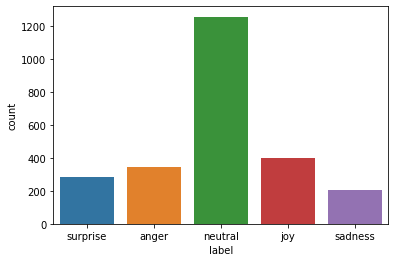

In [ ]:
sns.countplot(df_test_path['label'])

##Feature Extraction and Tokenizer

###MFCC

In [ ]:
n_features = 128
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=120)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_features)
    mfccScaled = np.mean(mfcc.T,axis=0)
    return mfccScaled

In [ ]:
# X_mfcc = df_tr_path['speech'].apply(lambda x: extract_mfcc(x))
# X_test_mfcc = df_test_path['speech'].apply(lambda x: extract_mfcc(x))
# np.save('./drive/MyDrive/Thesis_code/features/X_train_5emo_im-1.npy',X_mfcc)
# np.save('./drive/MyDrive/Thesis_code/features/X_test_5emo_im.npy',X_test_mfcc)

In [ ]:
X_mfcc = np.load('./drive/MyDrive/Thesis_code/features/X_train_5emo_bal.npy',allow_pickle=True)
X_test_mfcc = np.load('./drive/MyDrive/Thesis_code/features/X_test_5emo_bal.npy',allow_pickle=True)

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(3415, 128)

In [ ]:
X_test = [x for x in X_test_mfcc]
X_test = np.array(X_test)
X_test.shape

(2492, 128)

###BERT Tokenizer

In [ ]:
labelencoder = LabelEncoder()
df_tr_path['emotion_enc'] = labelencoder.fit_transform(df_tr_path['label'])
df_test_path['emotion_enc'] = labelencoder.fit_transform(df_test_path['label'])

In [ ]:
# y_train = np.array(df_tr_path['emotion_enc'])
# y_test = np.array(df_test_path['emotion_enc'])

In [ ]:
from transformers import BertTokenizer

sentences_train = df_tr_path.utterance.values
sentences_test = df_test_path.utterance.values

#check distribution of data based on labels
print("Distribution of train data based on labels: \n",df_tr_path.label.value_counts())
print("Distribution of test data based on labels: \n",df_test_path.label.value_counts())

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.

MAX_LEN = 256

## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case=True)

Distribution of train data based on labels: 
 surprise    683
neutral     683
sadness     683
anger       683
joy         683
Name: label, dtype: int64
Distribution of test data based on labels: 
 neutral     1256
joy          402
anger        345
surprise     281
sadness      208
Name: label, dtype: int64


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
print(len(sentences_test))

2492


In [ ]:
train_inputs = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences_train]
test_inputs = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences_test]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


##Define Ensemble Model

###XGBoost Classifier

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
# import xgboost as xgb
# from xgboost import XGBClassifier

# clf = XGBClassifier(n_estimators=180,learning_rate=0.01,subsample=0.75,max_depth=7,objective= 'multi:softmax',eval_metric='merror',num_class=5,reg_lambda=0.1,random_state=42)

###BiLSTM (try)

In [ ]:
#label onehotencoding
# enc = OneHotEncoder()
# y_train = enc.fit_transform(df_tr_path[['emotion_enc']])
# y_train = y_train.toarray()
# y_test = enc.fit_transform(df_test_path[['emotion_enc']])
# y_test = y_test.toarray()

In [ ]:
# from transformers import BertModel
# def get_bert_embed_matrix():
#     # bert = BertModel.from_pretrained('bert-base-uncased')
#     bert = BertModel.from_pretrained('distilbert-base-uncased')
#     bert_embeddings = list(bert.children())[0]
#     bert_word_embeddings = list(bert_embeddings.children())[0]
#     mat = bert_word_embeddings.weight.data.numpy()
#     return mat

In [ ]:
# embedding_matrix = get_bert_embed_matrix()

In [ ]:
# from tensorflow import keras
# import tensorflow as tf
# from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Lambda, LSTM, TimeDistributed, Masking, Bidirectional, AveragePooling2D, AveragePooling1D, MaxPool1D, Conv1D
# from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# # from keras.optimizers import Adam
# from keras.models import Model, load_model
# import keras.backend as K

# embed_size = 768 # how big is each word vector
# max_features = 30522 # how many unique words to use (i.e num rows in embedding vector)
# maxlen = 256 # max number of words in a question to use
# batch_size = 32 # how many samples to process at once

# reg = keras.regularizers.l2(l2=0.0001)
# opt = keras.optimizers.Adam(learning_rate=0.00001)

# text_input = Input(shape=(128, ))
# model_text1 = Embedding(max_features,
#                     embed_size,
#                     weights = [embedding_matrix],
#                     input_length = maxlen,
#                     trainable = False)(text_input)
# model_text2 = Bidirectional(LSTM(512, activation='tanh',return_sequences = True, dropout=0.1))(model_text1)
# model_text3 = Bidirectional(LSTM(256, activation='tanh',return_sequences = True, dropout=0.1))(model_text2)
# model_text4 = Bidirectional(LSTM(128, activation='tanh',return_sequences = False))(model_text3)
# model_text_flt = Flatten()(model_text4)
# # model_text_dense = Dense(64, activation='relu',kernel_regularizer=reg)(model_text_flt)
# model_text = Dropout(0.2)(model_text_flt)

# speech_input = Input(shape=(128,1))
# speech_mask = Masking(mask_value =0)(speech_input)
# model_speech1 = Bidirectional(LSTM(512, activation='tanh',return_sequences = True, dropout=0.4))(speech_mask)
# model_speech2 = Bidirectional(LSTM(256, activation='tanh',return_sequences = True, dropout=0.3))(model_speech1)
# model_speech3 = Bidirectional(LSTM(128, activation='tanh',return_sequences = False, dropout=0.3))(model_speech2)
# # model_sp_flt = Flatten()(model_speech3)
# model_speech = Flatten()(model_speech3)
# # model_sp_dense = Dense(64, activation='relu',kernel_regularizer=reg)(model_sp_flt)
# # model_speech = Dense(64, activation='relu',kernel_regularizer=reg)(model_sp_flt)
# # model_speech = Dropout(0.2)(model_sp_flt)

# # combination of text and speech
# model_combined1 = Concatenate()([model_text, model_speech])
# model_dense1 = Dense(1024,activation='relu',kernel_regularizer=reg)(model_combined1)
# model_combined2 = Dense(32, activation='relu',kernel_regularizer=reg)(model_dense1)
# model_combined3 = Dense(5, activation='softmax',kernel_regularizer=reg)(model_combined2)

# model_combined = Model([text_input, speech_input], model_combined3)
# model_combined.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

# # #model.compile()
# model_combined.summary()

##Train the Old Ensemble Models (not used)

###Train XGB

In [ ]:
#Fitting the model on train data
# clf.fit(X_train, y_train)
# clf.fit(np_concat_try, y_train)

###Train BiLSTM

In [ ]:
# Train the model
# num_epochs=40
# history = model.fit(X_train, y_train, validation_split=0.15, epochs=num_epochs, batch_size=32)

# hist = model_combined.fit([X_tr_text,X_audio], y_train, 
#                  batch_size=32, epochs=num_epochs, verbose=1, 
#                  validation_split=0.15)

##Evaluate Trained Model

###Load Baseline Unimodal Models

In [ ]:
from tensorflow import keras

bs1_audio = keras.models.load_model('drive/MyDrive/Thesis_code/model/baseline1_SER-5emo-bal')
bs1_text = keras.models.load_model('drive/MyDrive/Thesis_code/model/baseline1_TER-5emo-bal')

bs2_audio = keras.models.load_model('drive/MyDrive/Thesis_code/model/baseline2_SER-5emo-bal')
bs2_text = keras.models.load_model('drive/MyDrive/Thesis_code/model/baseline2_TER-5emo-bal')

###Load Proposed Unimodal Models

In [ ]:
model_audio = keras.models.load_model('drive/MyDrive/Thesis_code/model/BiLSTM_SER-5emo-bal')
model_text = keras.models.load_model('drive/MyDrive/Thesis_code/model/BiLSTM_TER-5emo-bal')

###Define Evaluation Metrics

In [ ]:
## emotion labels
label2int = {
  "anger": 0,
  "joy": 1,
  "neutral": 2,
  "sadness": 3,
  "surprise": 4
}

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

###Prepare Test Datasets

In [ ]:
X_test_text = np.array(test_inputs)
X_audio_test = X_test

In [ ]:
#label onehotencoding
enc = OneHotEncoder()
y_train = enc.fit_transform(df_tr_path[['emotion_enc']])
y_train = y_train.toarray()
y_test = enc.fit_transform(df_test_path[['emotion_enc']])
y_test = y_test.toarray()

###Predict using Baseline Models

In [ ]:
bs1_audio_prob = bs1_audio.predict(X_audio_test)
bs1_text_prob = bs1_text.predict(X_test_text)

bs2_audio_prob = bs2_audio.predict(X_audio_test)
bs2_text_prob = bs2_text.predict(X_test_text)

78/78 [==============================] - 9s 61ms/step


###Predict using Proposed Model

In [ ]:
audio_prob = model_audio.predict(X_audio_test)
text_prob = model_text.predict(X_test_text)

78/78 [==============================] - 7s 71ms/step


###Probabilities

In [ ]:
def voting_prob(prob_a,prob_b):
  raw_pred2=[]
  for i in range(len(prob_a)):
    if (max(prob_b[i]) >= max(prob_a[i])):
      raw_pred2.append(prob_b[i])
    else:
      raw_pred2.append(prob_a[i])
  raw_pred3 = np.array(raw_pred2)
  return raw_pred3

In [ ]:
raw_pred = voting_prob(audio_prob,text_prob)
raw_pred_bs1 = voting_prob(bs1_audio_prob, bs1_text_prob)
raw_pred_bs2 = voting_prob(bs2_audio_prob, bs2_text_prob)

In [ ]:
y_pred=np.argmax(raw_pred, axis=1)
y_pred_bs1=np.argmax(raw_pred_bs1, axis=1)
y_pred_bs2=np.argmax(raw_pred_bs2, axis=1)
# y_pred=np.argmax(raw_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

###Evaluate Baseline Models

In [ ]:
print(classification_report(y_true, y_pred_bs1, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

       anger    0.31707   0.33913   0.32773       345
         joy    0.30599   0.34328   0.32356       402
     neutral    0.75616   0.48885   0.59381      1256
     sadness    0.14925   0.28846   0.19672       208
    surprise    0.38210   0.62278   0.47361       281

    accuracy                        0.44302      2492
   macro avg    0.38211   0.41650   0.38309      2492
weighted avg    0.52991   0.44302   0.46668      2492



In [ ]:
print(classification_report(y_true, y_pred_bs2, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

       anger    0.29745   0.30435   0.30086       345
         joy    0.25265   0.29602   0.27262       402
     neutral    0.70418   0.38854   0.50077      1256
     sadness    0.13753   0.28365   0.18524       208
    surprise    0.30220   0.58719   0.39903       281

    accuracy                        0.37560      2492
   macro avg    0.33880   0.37195   0.33171      2492
weighted avg    0.48241   0.37560   0.39848      2492



###Evaluate Proposed Model

In [ ]:
cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[156  45  55  63  26]
 [140  99  76  58  29]
 [107  75 731 259  84]
 [ 49   9  79  60  11]
 [ 46  45  40  13 137]]


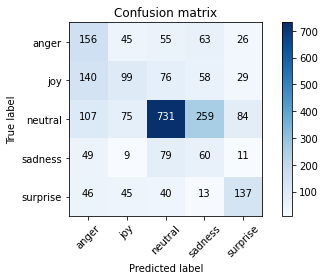

In [ ]:
plot_confusion_matrix(cm,label2int)

In [ ]:
print(classification_report(y_true, y_pred, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

       anger    0.31325   0.45217   0.37011       345
         joy    0.36264   0.24627   0.29333       402
     neutral    0.74516   0.58201   0.65355      1256
     sadness    0.13245   0.28846   0.18154       208
    surprise    0.47735   0.48754   0.48239       281

    accuracy                        0.47472      2492
   macro avg    0.40617   0.41129   0.39619      2492
weighted avg    0.54232   0.47472   0.49751      2492



###Save model

In [ ]:
#save the final bimodal model
# model_combined.save('drive/MyDrive/Thesis_code/model/BiLSTM_Bimodal-5emo-bal')